In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## LATC Model

In [3]:
def MAPE_loss(y_pred, y_true):
    """Mean Absolute Percentage Error

    MAPE(y_pred, y_true) = mean(|(y_true - y_pred) / y_true|)

    Args:
        y_pred (np.array): predicted values
        y_true (np.array): true values

    Returns:
        float: MAPE value"""

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



def RMSE_loss(y_pred, y_true):
    """Root Mean Squared Error

    RMSE(y_pred, y_true) = sqrt(mean((y_true - y_pred)**2))

    Args:
        y_pred (np.array): predicted values
        y_true (np.array): true values

    Returns:
        float: RMSE value"""

    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [4]:
def generalized_singular_threshold(M, theta, threshold=0.1):
    """Generalized Singular Value Thresholding.

    Compute the Generalized Singular Value Thresholding of a matrix.

    Args:
        M (np.ndarray): Matrix to threshold.
        theta (int): Number of singular values to keep.
        threshold (float, optional): Threshold value. Defaults to 0.1.

    Returns:
        np.ndarray: Thresholded matrix."""
    U, s, V = np.linalg.svd(M, full_matrices=False)
    idx = np.sum(s > threshold)
    vec = s.copy()
    vec[theta:idx] -= threshold
    return U[:, :idx] @ np.diag(vec[:idx]) @ V[:idx, :]

In [5]:
def unfold(x, mode):
    """Unfold a tensor along a given mode.
    Convert a tensor of shape (I_1, ..., I_N) to a matrix of shape (I_mode, I_1 * ... * I_{mode-1} * I_{mode+1} * ... * I_N).

    Args:
        x (np.ndarray): Tensor to unfold.
        mode (int): Mode along which to unfold the tensor.

    Returns:
        np.ndarray: Unfolded tensor."""
    # return np.moveaxis(x, mode, 0).reshape(x.shape[mode], -1)
    return np.moveaxis(x, mode, 0).reshape((x.shape[mode], -1), order = 'F')

def fold(x, mode, shape):
    """Fold a tensor along a given mode.
    Convert a matrix to a tensor from a given shape and a given mode.

    Args:
        x (np.ndarray): Tensor to fold.
        mode (int): Mode along which to fold the tensor.
        shape (tuple): Shape of the folded tensor.

    Returns:
        np.ndarray: Folded tensor."""
    x = x.reshape((shape[mode], *(shape[:mode] + shape[mode+1:])), order = 'F')
    return np.moveaxis(x, 0, mode)

In [6]:
class Imputer:

    def __init__(self, Y_true, Y_sparse, time_lags, alpha, lambd, theta):
        """Initialize the imputer.

        Args:
            Y_true (np.ndarray): The ground truth tensor of shape (n_sensors, period, repeat).
            Y_sparse (np.ndarray): The sparse tensor with missing values of shape (n_sensors, period, repeat).
            time_lags (np.ndarray): The time lags.
            alpha (float): The weight of each dimension.
            lambd (float): The penalty parameter.
            theta (int): The number of singular values to keep.
        """
        self.Y_true = Y_true
        self.Y_sparse = Y_sparse
        self.time_lags = time_lags
        self.alpha = alpha
        self.lambd = lambd
        self.theta = theta

        self.dim = Y_sparse.shape
        self.n_sensors, self.period, self.repeat = self.dim
        self.total_time = self.period * self.repeat
        self.max_lag = np.max(time_lags)
        self.n_lags = time_lags.shape[0]

        self.test_index = np.where((self.Y_sparse == 0) & (self.Y_true != 0))
        self.missing_index = np.where(unfold(self.Y_sparse, 0) == 0)

        self.init_tensors()

        self.time_matrix = np.zeros((self.n_lags, self.total_time - self.max_lag))
        for i in range(len(self.time_lags)):
            self.time_matrix[i, :] = np.arange(self.max_lag - self.time_lags[i], self.total_time - self.time_lags[i])
        self.time_matrix = self.time_matrix.astype(int)

        self.mape_losses = []
        self.rmse_losses = []
        self.tolerances = []
        self.rhos = []

    def init_tensors(self):
        self.T = np.zeros((3, *self.dim))
        self.X = np.zeros((3, *self.dim))
        self.Y_flat = unfold(self.Y_sparse, 0)
        self.Z = self.Y_flat.copy()

        self.Z[self.missing_index] = np.mean(self.Y_flat[self.Y_flat != 0])
        self.Y_test = self.Y_true[self.test_index]

        self.scaling_factor = 0.001
        self.A = np.random.rand(self.n_sensors, self.n_lags) * self.scaling_factor

        self.norm = np.linalg.norm(self.Y_flat, ord='fro')

    def fit(self, max_iterations=100, epsilon=1e-4, rho=1e-5):
        self.rho = rho

        prev_X_hat = self.Y_flat.copy()

        iteration = 0
        progress_bar = tqdm(total=max_iterations)

        while True:

            # Update pass
            self.update_X()

            X_hat_tensor = np.sum([self.alpha[k] * self.X[k] for k in range(3)], axis=0)
            X_hat = unfold(X_hat_tensor, 0)

            Qa = self.compute_Qa(X_hat)
            self.update_Z(Qa)

            self.T += self.rho * (self.X - fold(self.Z, 0, self.dim))

            # Compute loss and check convergence
            tolerance = np.linalg.norm(X_hat - prev_X_hat, ord='fro') / self.norm
            prev_X_hat = X_hat.copy()

            mape_error = MAPE_loss(X_hat_tensor[self.test_index], self.Y_test)
            rmse_error = RMSE_loss(X_hat_tensor[self.test_index], self.Y_test)

            self.mape_losses.append(mape_error)
            self.rmse_losses.append(rmse_error)
            self.tolerances.append(tolerance)
            self.rhos.append(self.rho)

            self.rho = min(1e5, self.rho * 1.05)

            iteration += 1
            progress_bar.update(1)
            progress_bar.set_description(f'{iteration}/{max_iterations} | Tolerance: {tolerance:.6} | MAPE: {mape_error:.2} | RMSE: {rmse_error:.2}')

            if tolerance < epsilon or iteration >= max_iterations: break

        progress_bar.close()

        mape_error = MAPE_loss(X_hat_tensor[self.test_index], self.Y_test)
        rmse_error = RMSE_loss(X_hat_tensor[self.test_index], self.Y_test)

        print("Training complete.")
        print(f'Tolerance: {tolerance:.6} | MAPE: {mape_error} | RMSE: {rmse_error}')

        return X_hat_tensor

    def update_X(self):
        """Update the X tensor.

        For each of the three modes, update the X tensor as follows:
            X_k = fold_k( D( fold_k(Z) - T_k / rho ) )
        where D is the generalized singular thresholding operator with threshold alpha_k / rho and theta singular values.

        i.e

        D(A) = U diag( max(s - 1_theta . alpha / rho, 0) ) V^T where A = U diag(s) V^T is the SVD of A.
        """
        for k in range(3):
            W = fold(self.Z, 0, self.dim) - self.T[k] / self.rho
            U = generalized_singular_threshold(unfold(W, k), self.theta, self.alpha[k] / self.rho)
            self.X[k] = fold(U, k, self.dim)

    def compute_Qa(self, X_hat):
        """Compute the products (Q_m a_m) with a_m solution of the problem
            min_a || Q_m a - Z_m,[h_d+1:] ||_2^2

        with a_m = Q_m^+ Z_m,[h_d+1:] = (Q_m Q_m^T)^-1 Q_m Z_m,[h_d+1:] as a solution.
        """
        N = np.zeros((self.n_sensors, self.total_time - self.max_lag))
        for m in range(self.n_sensors):
            Qm = X_hat[m, self.time_matrix].T
            self.A[m, :] = np.linalg.pinv(Qm) @ self.Z[m, self.max_lag:]
            N[m, :] = Qm @ self.A[m, :]
        return N

    def update_Z(self, Qa):
        """Update the Z tensor.

        Z_m,[:h_d] = 1/3 * sum_k unfold(X_k + T_k / rho)[:h_d]
        Z_m,[h_d+1:] = 1/3 * 1 / (lambda + rho) * sum_k unfold(X_k + T_k / rho)[h_d+1:] + lambda / (lambda + rho) * Q_m a_m

        As our goal is to retrieve the missing values, we only update the values of Z at the missing indices.
        """

        M = unfold(np.mean(self.rho * self.X + self.T, axis=0), 0)

        self.Z[self.missing_index] = np.append(
            M[:, :self.max_lag] / self.rho,
            1 / (self.rho + self.lambd) * (M[:, self.max_lag:] + self.lambd * Qa),
            axis=1
        )[self.missing_index]

## Missing Data Generation

In [7]:
from dataclasses import dataclass

@dataclass
class SparseGenerator:

    def random(self, tensor, sparisty):
        """Generate a sparse tensor from a given tensor and a given sparsity.

        Args:
            tensor (np.ndarray): The tensor to make sparse.
            sparisty (float): The sparsity of the generated tensor.

        Returns:
            np.ndarray: The sparse tensor.
        """
        return np.where(np.random.rand(*tensor.shape) < sparisty, 0, tensor)

    def block(self, tensor, block, sparisty):
        """Generate a non random sparse tensor from a given tensor and a given sparsity
        in which each time series has block missing for randomly selected days"""

        random_matrix = np.random.rand(tensor.shape[0], block)
        binary_tensor = np.round(random_matrix[:, None, :] + 0.5 - sparisty).astype(int)
        tensor = fold(tensor, 0, (tensor.shape[0], tensor.shape[1] // block, block))
        sparse_tensor = np.multiply(tensor, binary_tensor)

        return unfold(sparse_tensor, 0)


## PEMS Dataset

In [8]:
pems_path = r'C:\Antoine\Study\Master 2 - MVA\Chronological Series\Project\Low Rank Tensor Completion\data\California-data-set'
pems = pd.read_csv(pems_path + r'\pems-4w.csv', header=None)

In [9]:
sparse_pems_block = SparseGenerator().block(pems.values, 28, 0.3)
sparse_pems_random = SparseGenerator().random(pems.values, 0.3)

Text(0.5, 1.0, 'PEMS data (5min interval per day for 28 days)')

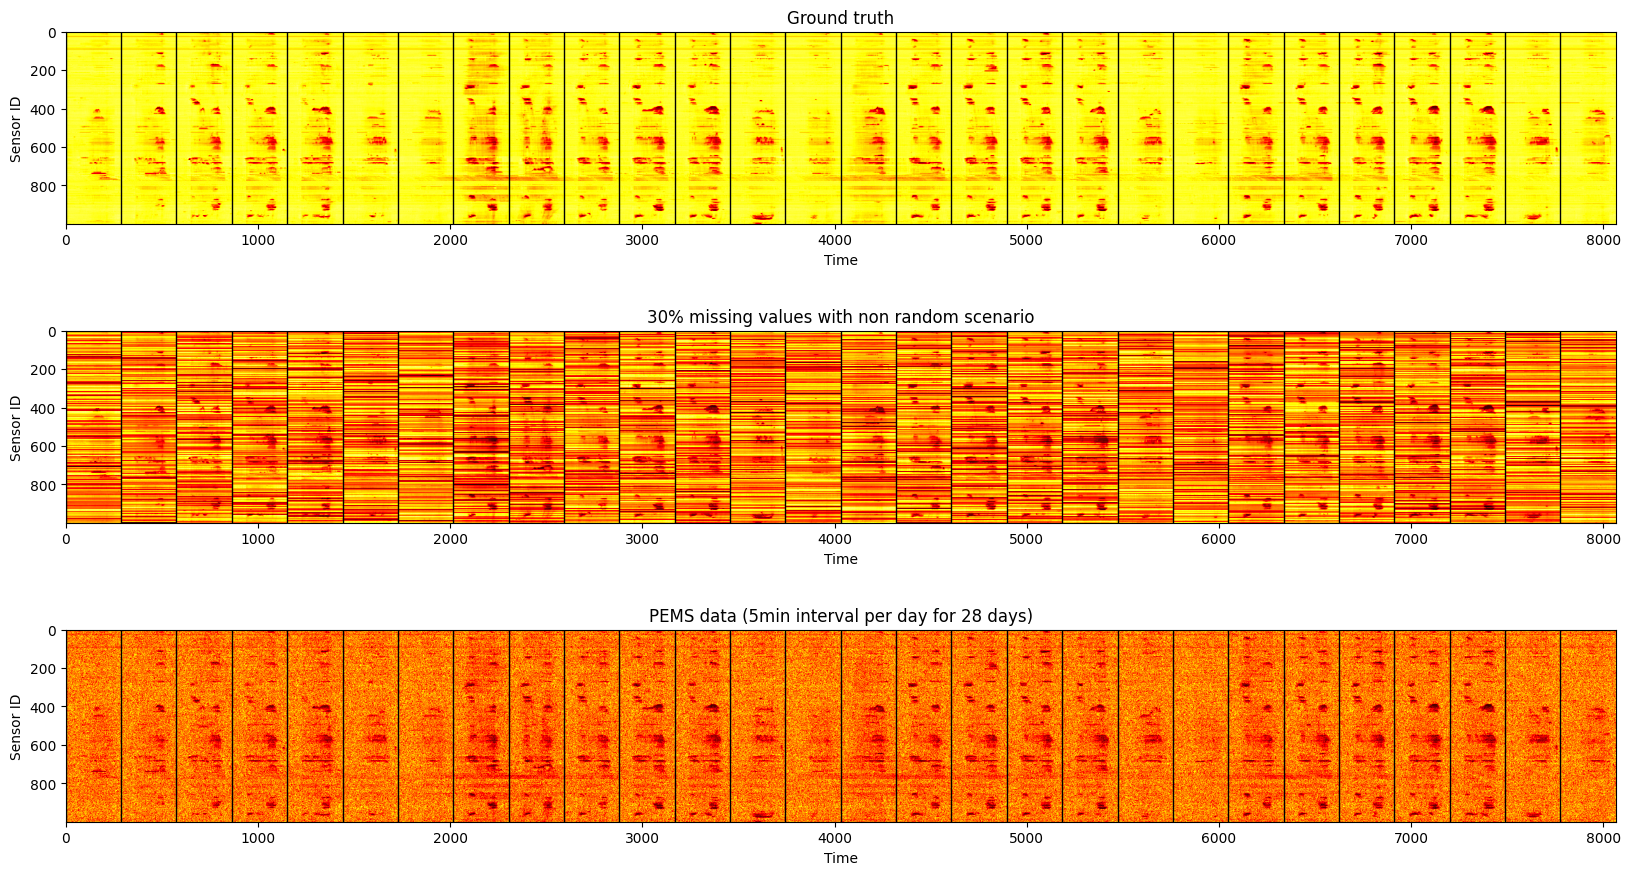

In [10]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(20, 11))

ax1.imshow(pems.values[:1000, :], cmap='hot')
for i in range(pems.shape[1] // 288):
    ax1.axvline(x=i * 288, color='black', linewidth=1)
ax1.set_xlabel('Time')
ax1.set_ylabel('Sensor ID')
ax1.set_title('Ground truth')

ax2.imshow(sparse_pems_block[:1000, :], cmap='hot')
for i in range(sparse_pems_block.shape[1] // 288):
    ax2.axvline(x=i * 288, color='black', linewidth=1)
ax2.set_xlabel('Time')
ax2.set_ylabel('Sensor ID')
ax2.set_title('30% missing values with non random scenario')

ax3.imshow(sparse_pems_random[:1000, :], cmap='hot')
for i in range(sparse_pems_random.shape[1] // 288):
    ax3.axvline(x=i * 288, color='black', linewidth=1)
ax3.set_xlabel('Time')
ax3.set_ylabel('Sensor ID')
ax3.set_title('30% missing values with random scenario')


plt.title('PEMS data (5min interval per day for 28 days)')

## Training

#### Hyperparameters

In [11]:
time_lags = np.array([1, 2, 3, 4, 5, 6] + [288 - 2, 288 - 1, 288, 288 + 1, 288 + 2, 288 + 3])
rho = 1e-4
lambd = 5*rho
theta = 15
epsilon = 1e-4

alpha = np.array([1, 1, 1]) / 3

#### Non Random Scenario

In [12]:
subset_sparse = sparse_pems_block[:100, :]
subset_true = pems.values[:100, :]

subset_sparse_tensor = fold(subset_sparse, 0, (subset_sparse.shape[0], 288, 28))
subset_true_tensor = fold(subset_true, 0, (subset_true.shape[0], 288, 28))

print(subset_sparse_tensor.shape)
print(subset_true_tensor.shape)

(100, 288, 28)
(100, 288, 28)


In [13]:
model_non_random = Imputer(subset_true_tensor, subset_sparse_tensor, time_lags, alpha, lambd, theta)

In [14]:
model_non_random.fit(max_iterations=100, epsilon=epsilon, rho=rho)
print()

  0%|          | 0/100 [00:00<?, ?it/s]

Training complete.
Tolerance: 0.000794171 | MAPE: 1.6890094143935337 | RMSE: 1.9884203760307038



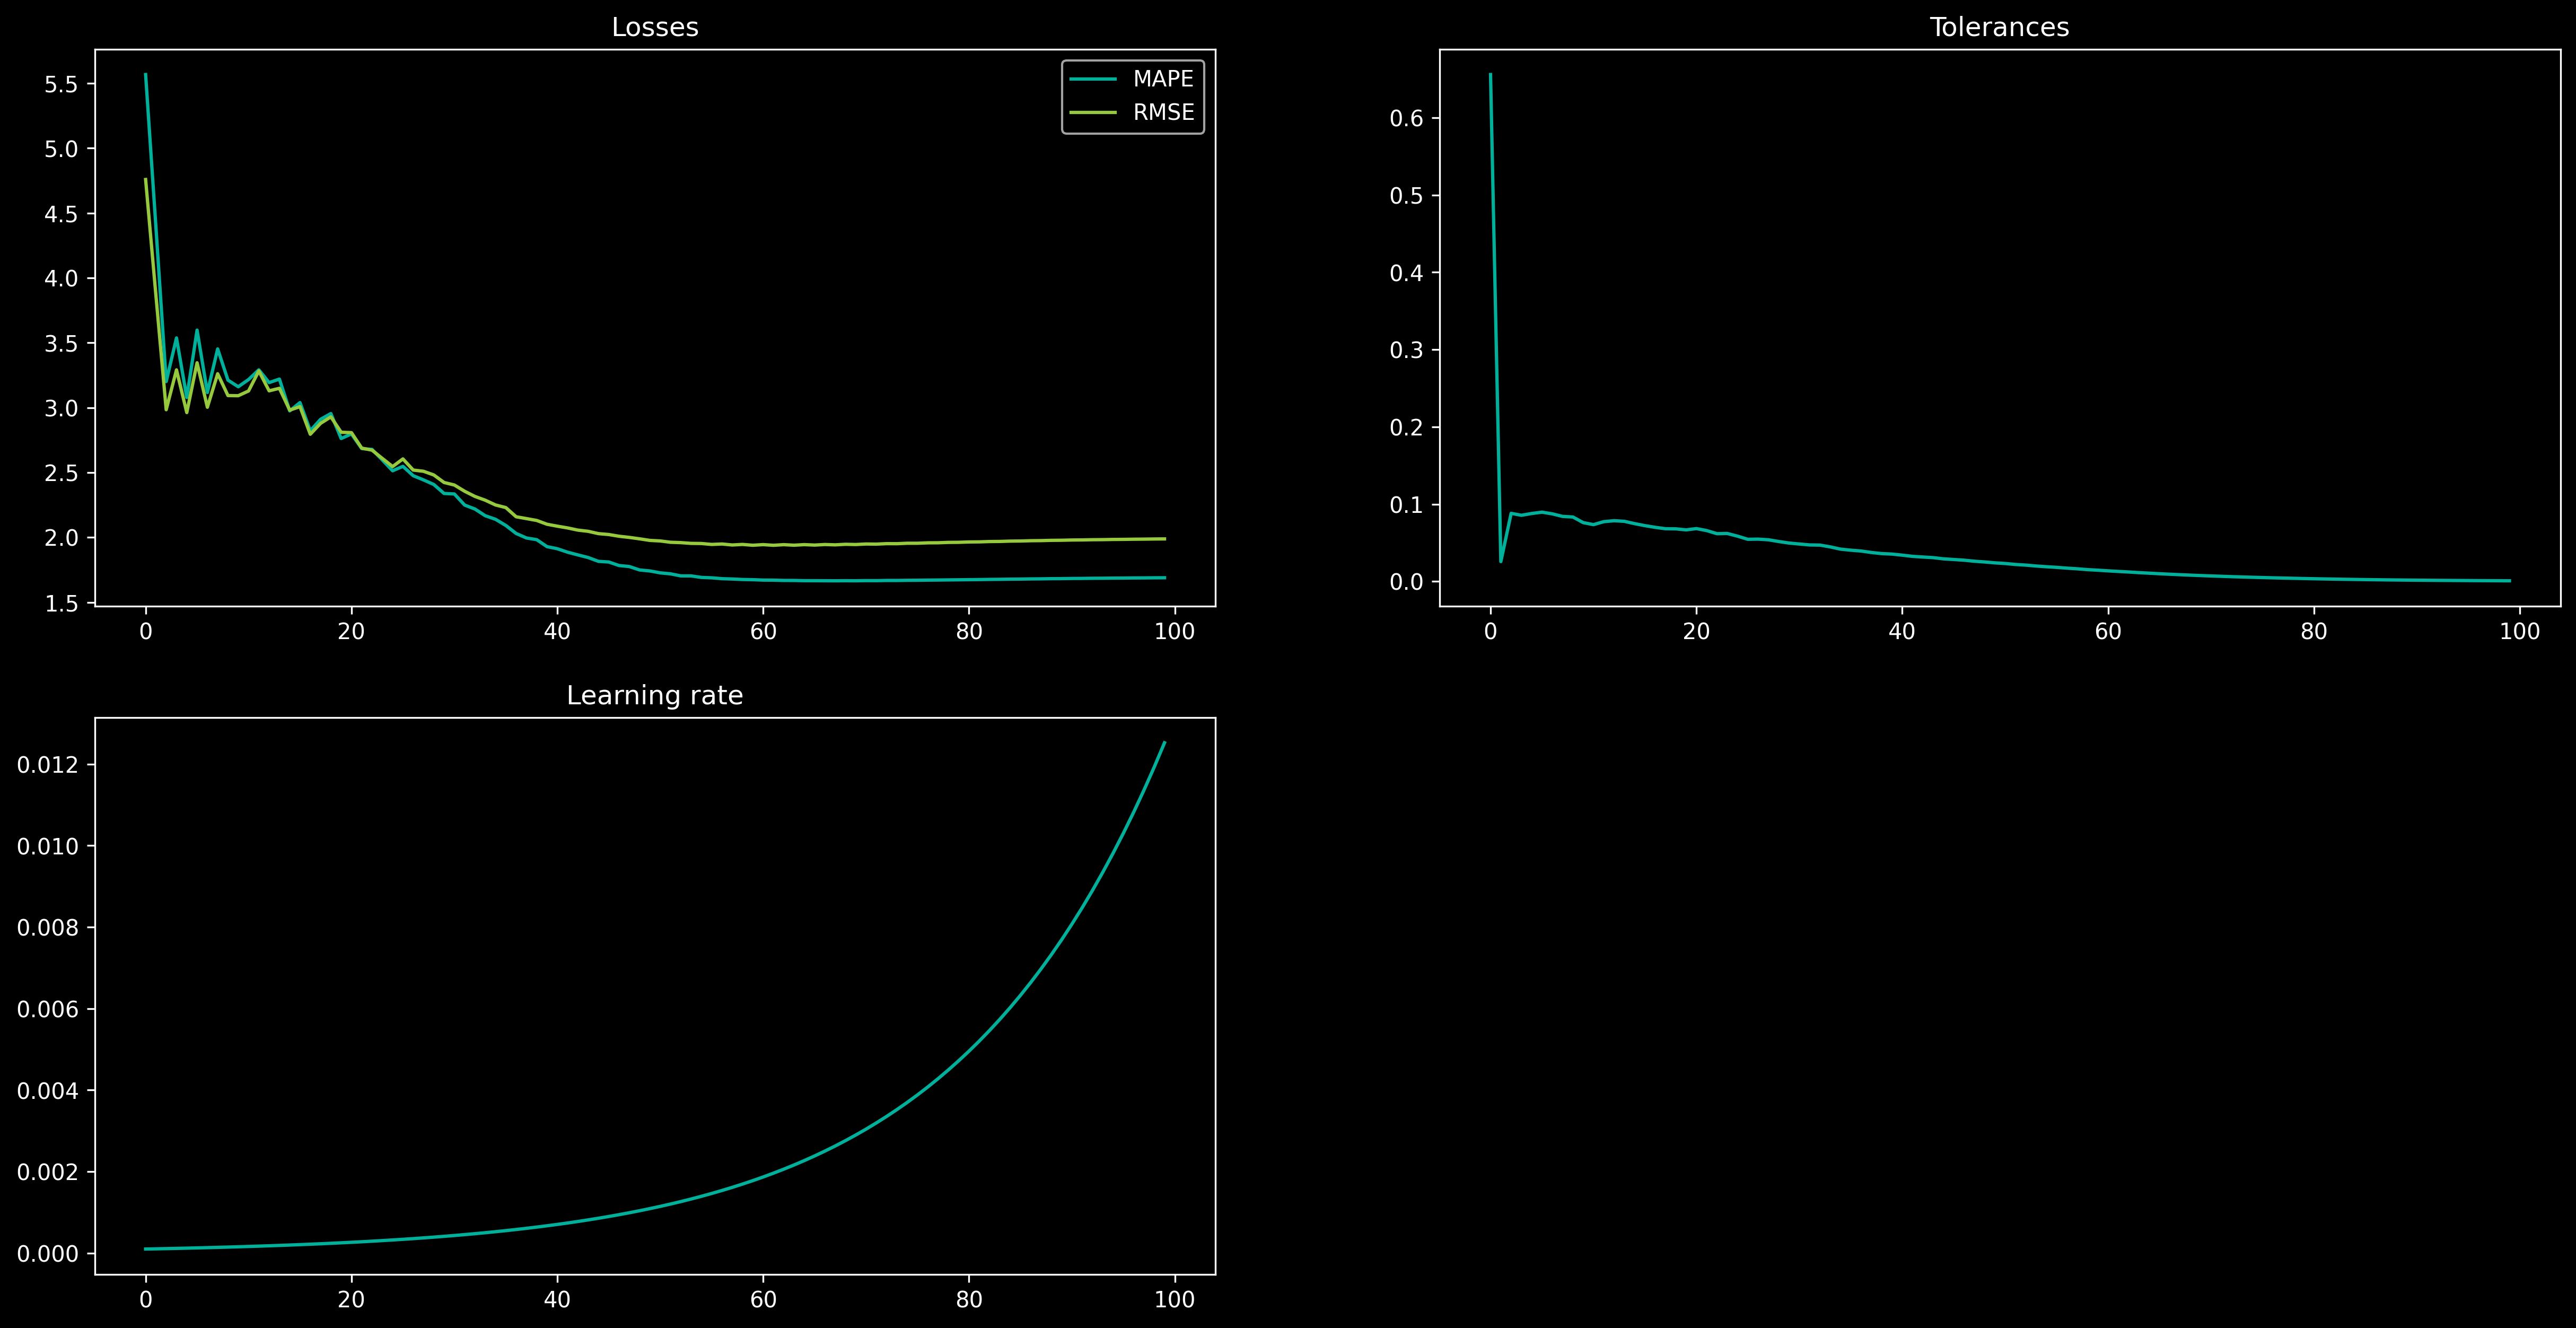

In [20]:
# Plot the losses

plt.figure(figsize=(20, 10), dpi=300)
plt.style.use('dark_background')

plt.subplot(2, 2, 1)
plt.plot(model_non_random.mape_losses, label='MAPE', color='#00b09b')
plt.plot(model_non_random.rmse_losses, label='RMSE', color='#96c93d')
plt.legend()
plt.title('Losses')

# Plot the tolerances
plt.subplot(2, 2, 2)
plt.plot(model_non_random.tolerances, color='#00b09b')
plt.title('Tolerances')

# Plot the rhos
plt.subplot(2, 2, 3)
plt.plot(model_non_random.rhos, color='#00b09b')
plt.title('Learning rate')
plt.show()

### Random Scenario

In [16]:
subset_sparse = sparse_pems_random[:100, :]
subset_true = pems.values[:100, :]

subset_sparse_tensor = fold(subset_sparse, 0, (subset_sparse.shape[0], 288, 28))
subset_true_tensor = fold(subset_true, 0, (subset_true.shape[0], 288, 28))

print(subset_sparse_tensor.shape)
print(subset_true_tensor.shape)

(100, 288, 28)
(100, 288, 28)


In [17]:
model_random = Imputer(subset_true_tensor, subset_sparse_tensor, time_lags, alpha, lambd, theta)

In [18]:
model_random.fit(max_iterations=100, epsilon=epsilon, rho=rho)
print()

  0%|          | 0/100 [00:00<?, ?it/s]

Training complete.
Tolerance: 0.00069422 | MAPE: 0.8060828674527645 | RMSE: 0.9193430020488139



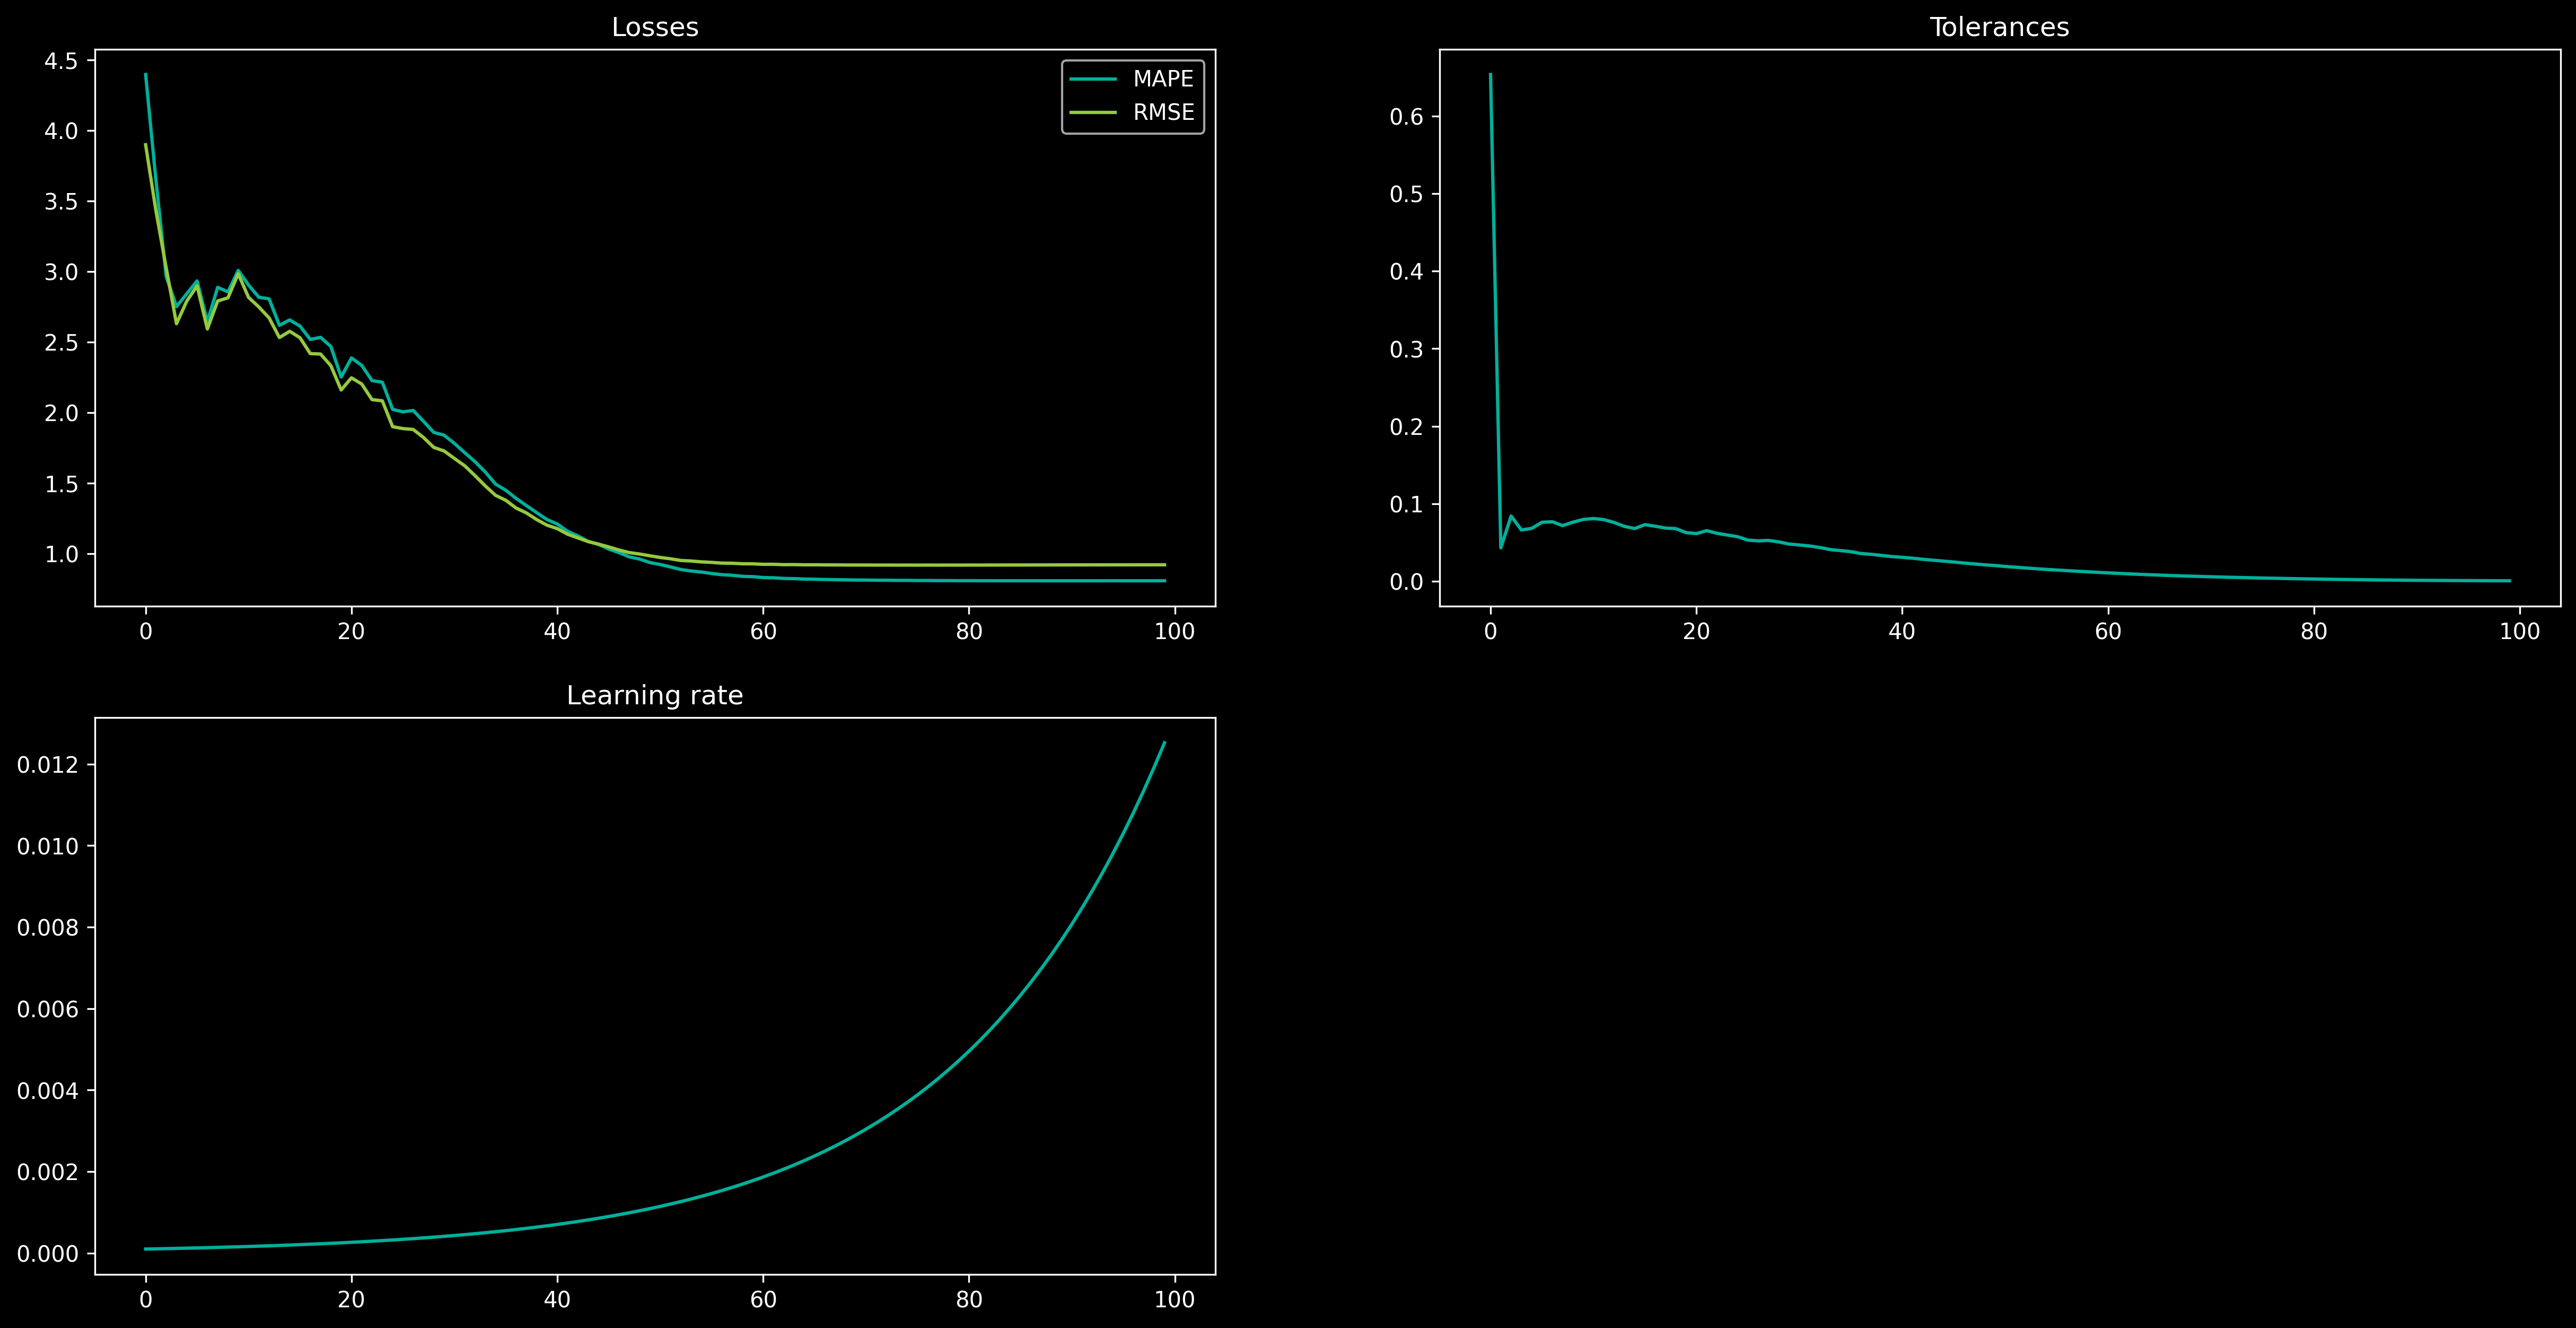

In [21]:
# Plot the losses

plt.figure(figsize=(20, 10), dpi=300)
plt.style.use('dark_background')

plt.subplot(2, 2, 1)
plt.plot(model_random.mape_losses, label='MAPE', color='#00b09b')
plt.plot(model_random.rmse_losses, label='RMSE', color='#96c93d')
plt.legend()
plt.title('Losses')

# Plot the tolerances
plt.subplot(2, 2, 2)
plt.plot(model_random.tolerances, color='#00b09b')
plt.title('Tolerances')

# Plot the rhos
plt.subplot(2, 2, 3)
plt.plot(model_random.rhos, color='#00b09b')
plt.title('Learning rate')
plt.show()